In [1]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import collections
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy
import pandas as pd
from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
class _ListDict_(object):
    
    def __init__(self):
        self.item_to_position = {}
        self.items = []

    def __len__(self):
        return len(self.items)

    def add(self, item):
        if item in self.item_to_position:
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove(self, item):
        if item in self.item_to_position:
            position = self.item_to_position.pop(item)
            del self.items[position]
            for i in range(len(self.items)):
                if i >= position:
                    self.item_to_position[self.items[i]] = self.item_to_position[self.items[i]] - 1

    def choose_random(self):
        return random.choice(self.items)
    
    def __repr__(self):
         return repr(self.items)

    def __str__(self):
         return str(self.items)

In [3]:
def initialize_SIS_(G, initial_infecteds, infection_times, recovery_times, tmin):
    times = [tmin]
    S = [G.order()-len(initial_infecteds)]
    I = [len(initial_infecteds)]
    status = defaultdict(lambda:'S') #by default all are susceptible
    infected = list(initial_infecteds)
    infected_neighbor_count = defaultdict(lambda:0)
    risk_group = defaultdict(lambda:_ListDict_()) 
    
    for node in initial_infecteds:
        status[node] = 'I'
    for node in initial_infecteds:
        for neighbor in G.neighbors(node):
            if status[neighbor] == 'S':
                infected_neighbor_count[neighbor] += 1
                if infected_neighbor_count[neighbor] > 1:
                    risk_group[infected_neighbor_count[neighbor]-1].remove(
                                                                    neighbor)
                        
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)

    return times, S, I, status, infected, infected_neighbor_count, risk_group

In [4]:
def infect(G, S, I, R, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    
    for n in risk_group.keys():
        r -= n*len(risk_group[n])
        if r < 0:
            break

    recipient = risk_group[n].choose_random()
    
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient] = 'I'
    S.append(S[-1] - 1)
    I.append(I[-1] + 1)
    times.append(current_time)

    for neighbor in G.neighbors(recipient):
        if status[neighbor] == 'S':
            if infected_neighbor_count[neighbor] > 0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] += 1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)

In [5]:
def recover(G, S, I, times, infected, current_time, status, 
            infected_neighbor_count, risk_group, recovery_times):
    
    index = random.randint(0, I[-1] - 1)
    infected[index], infected[-1] = infected[-1], infected[index]
    recovering_node = infected.pop()

    I.append(I[-1] - 1)
    status[recovering_node] = 'S'
    S.append(S[-1] + 1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else:
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(recovering_node)

In [6]:
def SIS(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            infect(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')
        

    return scipy.array(times), scipy.array(S), scipy.array(I)

In [7]:
df = pd.read_excel('assoc_eng.xlsx')
G = nx.from_pandas_dataframe(df, 'Source', 'Target', edge_attr=None, create_using=nx.DiGraph())

### Превратим семантическую сеть в ненаправленную сеть

In [8]:
H = G.to_undirected()

In [9]:
A = nx.adjacency_matrix(H)
A = A.todense()
max_eigval = max(LA.eigvals(A))

In [10]:
max_eigval

36.56281961644973

In [11]:
1 / max_eigval

0.02735018826475015

In [ ]:
initial_size = 100
init_infected = random.sample(set(G.nodes), 100)
gamma = 1.
tau = 0.5
t, S, I = SIS(H, tau, gamma, tmax = 40, initial_infecteds = init_infected)

plt.plot(t, I)

In [9]:
def get_stability_time(inf_arr, num_steps, interval, eps, threshold):
    count = 0
    stab_time = num_steps
    for i, j in zip(np.arange(0, num_steps - interval, 1), np.arange(interval, num_steps, 1)):
        if abs(inf_arr[j] - inf_arr[i]) < eps:
            count += 1
        else:
            count = 0
        if count > threshold:
            stab_time = i
            break
    return stab_time        

In [11]:
num_init_infected = 100
init_inf = random.sample(set(H.nodes()), num_init_infected)

In [12]:
p_inf_arr = np.linspace(0.01, 0.4, 10)
p_inf_arr

array([ 0.01      ,  0.05333333,  0.09666667,  0.14      ,  0.18333333,
        0.22666667,  0.27      ,  0.31333333,  0.35666667,  0.4       ])

In [14]:
initial_size = 100
gamma = 1.
t_stab = []
std_array = []
Inf_array = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for i in range(10):
        t, S, I = SIS(H, prob, gamma, tmax = 20, initial_infecteds = init_inf)
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis = -1)
    std_inf = [np.std(lst) for lst in ens_inf]
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    
    Inf_array.append(avrg_inf)
    
    std_array.append(std_inf[stab_time - 1])
    t_stab.append(t[stab_time - 1])

--------------------------------
('infection probability: ', 0.01)
--------------------------------
('infection probability: ', 0.053333333333333337)
--------------------------------
('infection probability: ', 0.096666666666666665)


KeyboardInterrupt: 

In [ ]:
tau_arr = np.linspace(0.001, 0.2, 10)
tau_arr

In [ ]:
initial_size = 100
gamma = 1.
tau = 0.004
init_inf = random.sample(set(G.nodes), initial_size)
I_arr, t_arr = [], []
for tau in (tau_arr):
    print(tau)
    t, S, I = SIS(G, tau, gamma, tmax = 150,
                        initial_infecteds = init_inf)
    I_arr.append(I)
    t_arr.append(t)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [16]:
tau_arr = np.linspace(0.001, 0.4, 10)
tau_arr

array([ 0.001     ,  0.04533333,  0.08966667,  0.134     ,  0.17833333,
        0.22266667,  0.267     ,  0.31133333,  0.35566667,  0.4       ])

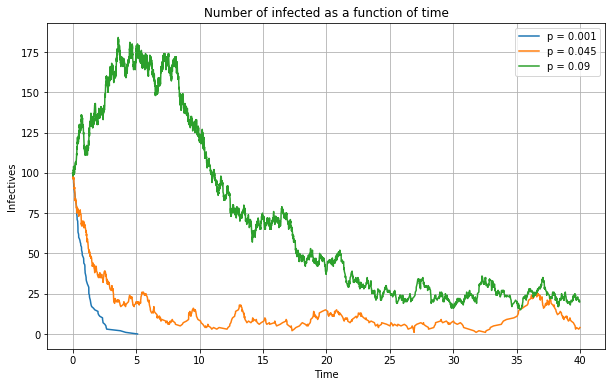

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

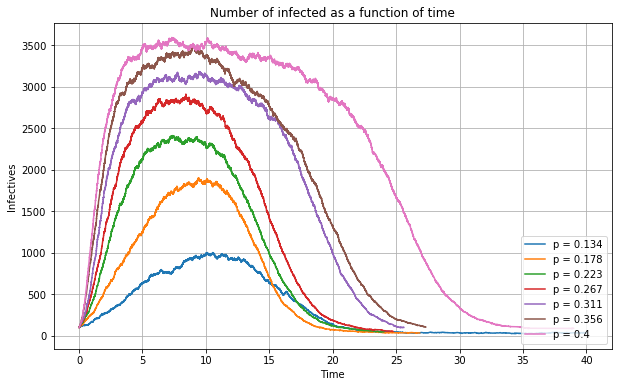

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()